# Test the trained model with visualization

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from dataloader import Dataloader
from models.ViT_MAE.vit_translation import ViT_Translation

/nfs/home/clruben/workspace/nst/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load saved model

In [5]:
def load_model(model, path_to_checkpoint):
    config_path = os.path.join(path_to_checkpoint, 'config.json')
    parameters_path = os.path.join(path_to_checkpoint, 'parameters.torch')
    with open(config_path) as f:
        config = json.load(f)
    model = model(**config["model"])
    checkpoint = torch.load(parameters_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

path_to_checkpoint = "/nfs/home/clruben/workspace/nst/models/ViT_MAE/checkpoints/vit_mae-08-04-2023-09_33_00"
model = load_model(ViT_Translation, path_to_checkpoint)

device = torch.device("cuda:0")
model.to(device)

model.eval()
print("Done.")

Done.


### 2. Load test dataset

In [3]:
source = "/nfs/home/clruben/workspace/nst/data/"

ct = Dataloader(source, "test", "CT")
mr = Dataloader(source, "test", "MR")

### 3. Test the model on some images

In [23]:
def to_numpy(torch_variable):
    return torch_variable.detach().cpu().numpy()

ct_image = torch.tensor(ct[0]).to(device)
with torch.no_grad():
    outputs = model(ct_image)

pred = to_numpy(model.unpatchify(outputs.pred))
mask = to_numpy(outputs.mask)

In [41]:
input_img = mr[0][0][0]
pred_img = pred[0][0]
mask_reshaped = mask[0].reshape(32,32)
def apply_mask(img, mask):
    img_copy = img.copy()
    mask_size = img.shape[0]//mask.shape[0]
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] == 1:
                img_copy[i*mask_size:(i+1)*mask_size, j*mask_size:(j+1)*mask_size] = 0
    return img_copy
masked_img = apply_mask(input_img, mask_reshaped)

(-0.5, 511.5, 511.5, -0.5)

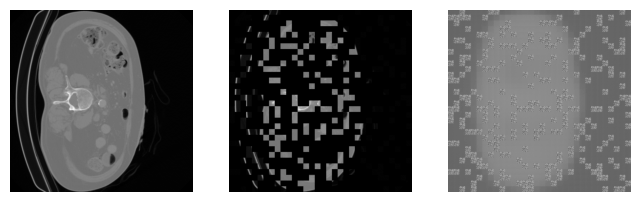

In [53]:
# show input_img, masked_img, and pred_img side by side with subplots
f, axarr = plt.subplots(1,3, figsize=(8, 8))

axarr[0].imshow(input_img, cmap='gray')
axarr[0].axis('off')
axarr[1].imshow(masked_img, cmap='gray')
axarr[1].axis('off')
axarr[2].imshow(pred_img, cmap='gray')
axarr[2].axis('off')
